First import required packages and functions.

In [1]:
import scipy.io as sio
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.distributions import Normal

from tqdm import tqdm_notebook

# Indiana Pines

Load the data.

In [2]:
def load_data(img_path, target_path, img_dict_el, target_dict_el):
    """Given imformation about the path and the location of the data, loads it and then transforms.
    
    Parameters
    ----------
    img_path: str
        Path to the images.
    target_path: str
        Path to the ground truth labels.
    img_dict_el: str
        Dictionary sell where the images are stored.
    target_dict_el: str
        Dictionary sell where the target labels are stored.
        
    Returns
    -------
    X: numpy.ndarray
        Loaded and transformed images.
    y: numpy.ndarray
        Loaded and transformed for the future convenience labels
    """
    X = sio.loadmat(img_path)[img_dict_el]
    y = sio.loadmat(target_path)[target_dict_el]
    
    for cl in np.unique(y): # See the class labels' distribution.
        print(cl, np.sum(y == cl))
    
    # Shift and scale it so that it will have zero mean and unit standard deviation.
    X = X.transpose((2, 0, 1))
    C, H, W = X.shape
    X = X.reshape(1, C, H, W)
    dataset_mean = X.mean()
    dataset_std = X.std()
    X = (X - dataset_mean) / dataset_std
    y = y.reshape(-1) # repeat y for convenient use of classificator
    return X, y

In [3]:
X, y = load_data('data/Indian_pines_corrected.mat', 'data/Indian_pines_gt.mat', 'indian_pines_corrected', 'indian_pines_gt')

0 10776
1 46
2 1428
3 830
4 237
5 483
6 730
7 28
8 478
9 20
10 972
11 2455
12 593
13 205
14 1265
15 386
16 93


Define encoder and decoder.

In [4]:
def get_classification_performance(encoder, img, y):
    """Gets dataset, splits it to the training and validation set, 
    fits LogisticRegression(ANN) and returns misclassified pixels percentage.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
    y: numpy.ndarray
        Ground truth labels of the given dataset.
        
    Returns
    -------
    error: float
        Misclassification of pixels percentage.
    """
    features_raw = encoder(img) # get encoder output
    features_raw = features_raw.data.numpy().copy() # and conert it to the numpy
    
    # flatten and split to the training and validation parts to fit LogisticRegression(ANN) on this data
    N, C, H, W = features_raw.shape
    features = features_raw.reshape(C, -1)
    features = features.T
    
    # perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 10 folds
    scores_train = []
    scores_test = []
    for train_indices, test_indices in skf.split(features, y):
        logreg = LogisticRegression()
        logreg.fit(features[train_indices], y[train_indices])
        train_acc = accuracy_score(y[train_indices], logreg.predict(features[train_indices]))
        test_acc = accuracy_score(y[test_indices], logreg.predict(features[test_indices]))
        scores_train.append(train_acc)
        scores_test.append(test_acc)
    
    acc_train = np.mean(scores_train)
    acc_test = np.mean(scores_test)
    return acc_train, acc_test

In [5]:
def init_autoencoder(X, in_channels=200, lr=0.001, reg=0):
    encoder = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=100, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_features=100),
                        nn.Conv2d(in_channels=100, out_channels=50, kernel_size=3, padding=1),
                        nn.ReLU(), 
                        nn.BatchNorm2d(num_features=50))
    decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=50, out_channels=100, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=100),
                            nn.ConvTranspose2d(in_channels=100, out_channels=in_channels, kernel_size=5, padding=2),
                            nn.ReLU())
    
    # define loss as MSE and optimization method as Adam. Also convert the dataset to the PyTorch format
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001, weight_decay=reg)
    img = Variable(torch.FloatTensor(X.copy()))
    return (encoder, decoder, optimizer, loss_function), img

In [6]:
def train_autoencoder(model, img, y, epochs=5):
    """Trains defined globally called encoder-decoder network.
    
    Parameters
    ----------
    img: torch.autograd.Variable.
        Dataset to train the net
    epochs: int, default: 5
        Number of passes through the full dataset.
    y: numpy.ndarray
        Ground truth labels of the given dataset. Used to check classification performance
        
    Returns
    -------
    loss: float
        Result loss value.
    losses: list
        Losses history for each epoch.
    """
    encoder, decoder, optimizer, loss_function = model
    
    performance_train = []
    performance_test = []
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad() # set gradient values to zero. Just PyTorch stuff
        encoder_out = encoder(img) # get encoded image
        decoder_out = decoder(encoder_out) # and then decode it
        loss = loss_function(decoder_out, img) # calculate the loss value
        losses.append(loss.data.numpy().copy()[0])
        loss.backward() # and compute gradients
        optimizer.step() # make optimization step
        
        acc_train, acc_test = get_classification_performance(encoder, img, y)
        performance_train.append(acc_train)
        performance_test.append(acc_test)
    
        clear_output()
        plt.plot(losses, label="Loss")
        plt.plot(performance_train, label="Train accuracy")
        plt.plot(performance_test, label="Test accuracy")
        plt.xlim([0, epochs - 1])
        plt.legend()
        plt.show()
        
    encoder_out = encoder(img)
    decoder_out = decoder(encoder_out)
    loss = loss_function(decoder_out, img)
    return loss, losses, performance_train, performance_test

def plt_map(act_map):
    """Plots given activation map of the convolution layer.
    
    Parameters
    ----------
    act_map: torch.autograd.Variable
        Activation map which will be plotted
    """
    N = act_map.data.shape[0]
    
    plt.figure(figsize=(10, 10))
    _, axes = plt.subplots(N // 10 + int(N % 10), 10)
    for ax in axes.reshape(-1):
        ax.axis('off')
    for i, filter_ in enumerate(act_map.data.numpy()):
        axes[i // 10, i % 10].imshow(filter_);
#     plt.show();
        
def get_and_plot_act_map(encoder, img):
    """Extracts layer and it's activation map passed one image.
    
    Parameters
    ----------
    img: torch.autograd.Variable
        Dataset.
        
    Returns:
    activations: torch.autograd.Variable
        activation map on the first convolutional layer.
    """
    
    _, first_layer = list(encoder._modules.items())[0] # get networks' first layer 
    activations = first_layer(img) # and get activation values
    plt_map(activations.squeeze())
    return activations

Train the model.

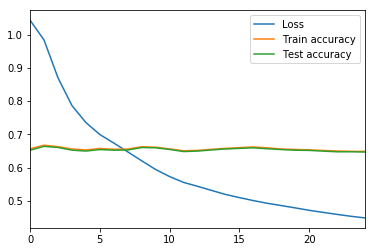

Variable containing:
 0.4443
[torch.FloatTensor of size 1]



<Figure size 720x720 with 0 Axes>

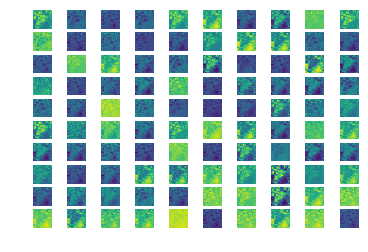

In [7]:
model, img = init_autoencoder(X)
reconstruction_error, losses, performance_train, performance_test = train_autoencoder(model, img, y, 25)
activations = get_and_plot_act_map(model[0], img) # save activations of the first convolutional layer
print(reconstruction_error)

In [8]:
error = get_classification_performance(model[0], img, y)
print(error)

(0.6488150153777568, 0.6468626849089827)


In [16]:
print("Best number of epochs: %d, Best test accuracy: %.5f" % (np.argmax(performance_test) + 1, 
                                                               np.amax(performance_test)))

Best number of epochs: 2, Best test accuracy: 0.66388


# Salinas-A

Now let's fine-tune autoencoder and classifier to check their performance on the Salinas-A dataset.

In [9]:
X, y = load_data('data/SalinasA_corrected.mat', 'data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt')
img = Variable(torch.FloatTensor(X.copy()))

0 1790
1 391
10 1343
11 616
12 1525
13 674
14 799


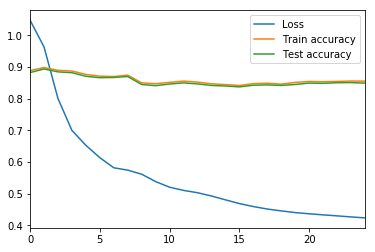

Variable containing:
 0.4218
[torch.FloatTensor of size 1]



<Figure size 720x720 with 0 Axes>

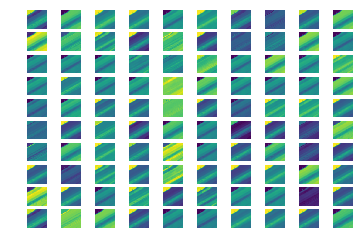

In [12]:
model, img = init_autoencoder(X, in_channels=204)
reconstruction_error, losses_salinas, performance_train_salinas, performance_test_salinas = train_autoencoder(model, img, y, epochs=25)
activations = get_and_plot_act_map(model[0], img)
print(reconstruction_error)

In [13]:
error = get_classification_performance(model[0], img, y)
print(error)

(0.8557018610530781, 0.8493867586478014)


In [17]:
print("Best number of epochs: %d, Best test accuracy: %.5f" % (np.argmax(performance_test_salinas) + 1, 
                                                               np.amax(performance_test_salinas)))

Best number of epochs: 2, Best test accuracy: 0.89410


# Compare
It can be seen that first dataset requires much more training and even after that shows less performance. It should be caused by the dataset's properites.
Also it can be clearly seen that autoencoder overfits as we increase the number of epochs over 2.